In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

Package,Version
matplotlib,3.10.7
pandas,2.3.3
scanpy,1.11.5
Component,Info
Python,"3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]"
OS,Windows-11-10.0.26200-SP0
CPU,"32 logical CPU cores, AMD64 Family 25 Model 97 Stepping 2, AuthenticAMD"
GPU,"ID: 0, NVIDIA GeForce RTX 5060 Laptop GPU, Driver: 577.03, Memory: 8151 MiB"
Updated,2025-10-27 00:45
Dependency,Version


In [3]:
results_file = "write/pbmc3k.h5ad"

In [4]:
adata = sc.read_10x_mtx(
    "pbmc3k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/hg19/", 
    var_names="gene_symbols", 
    cache=True, 
)

... reading from cache file cache\pbmc3k_filtered_gene_bc_matrices-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [6]:
adata.var_names_make_unique()

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Data Preprocessing

normalizing counts per cell
    finished (0:00:00)


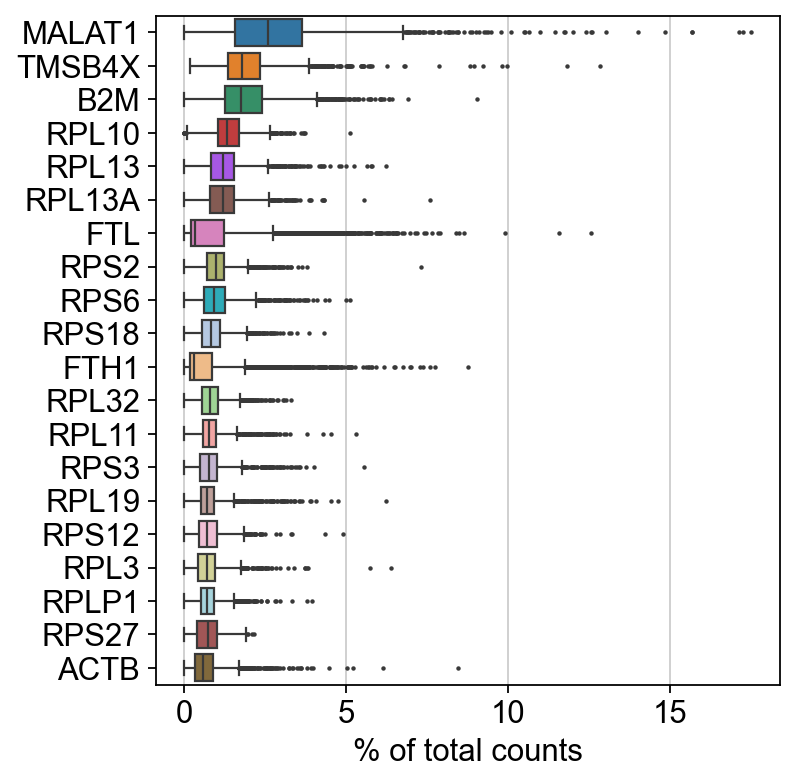

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [10]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

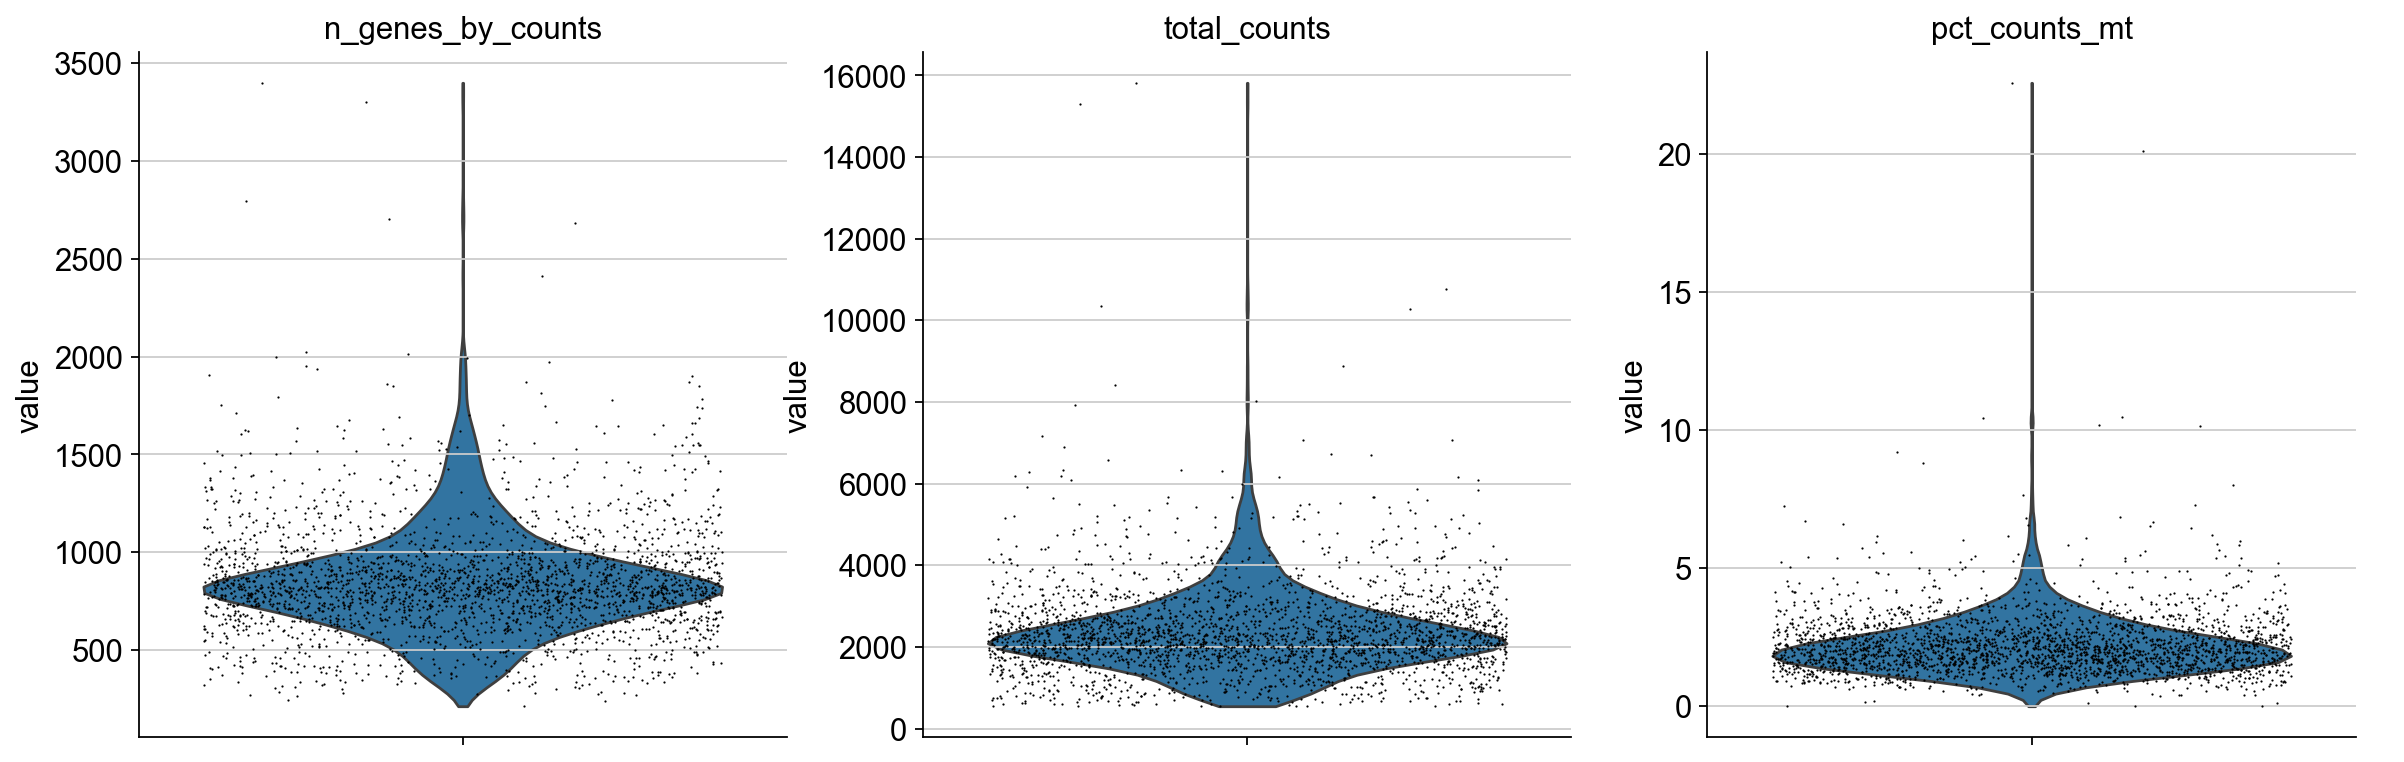

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [12]:
adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

In [13]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [17]:
adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:00)


## Principal Component Analysis (PCA)

In [18]:
sc.pp.pca(adata, layer="scaled", svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


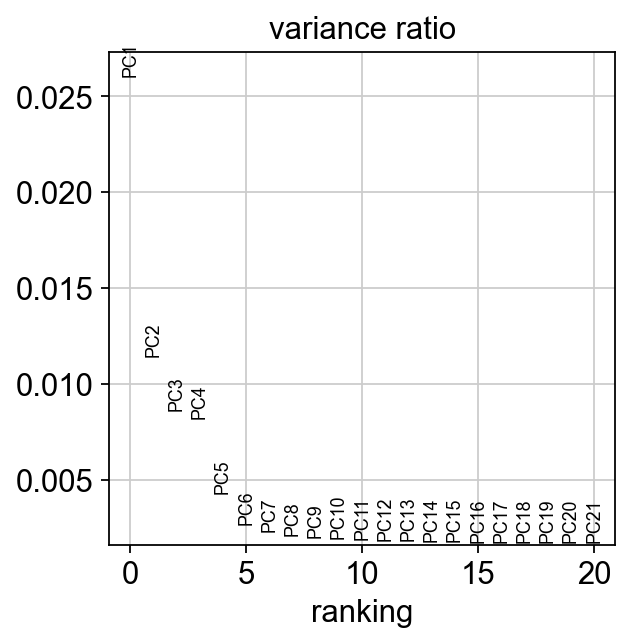

In [19]:
sc.pl.pca_variance_ratio(adata, n_pcs=20)

## Computing the neighborhood graph

In [20]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


## UMAP

In [21]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


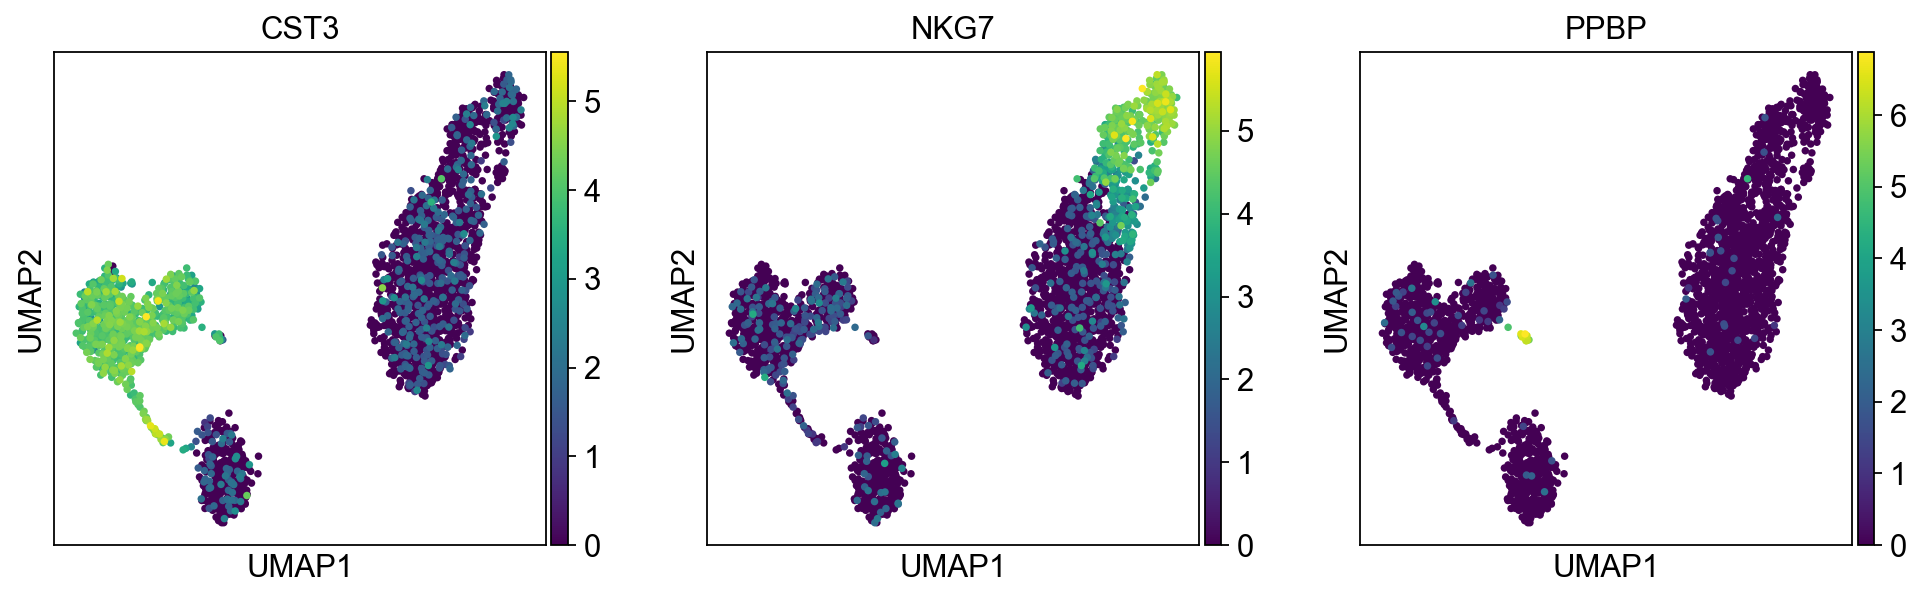

In [22]:
# Using normalized gene expression, 
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

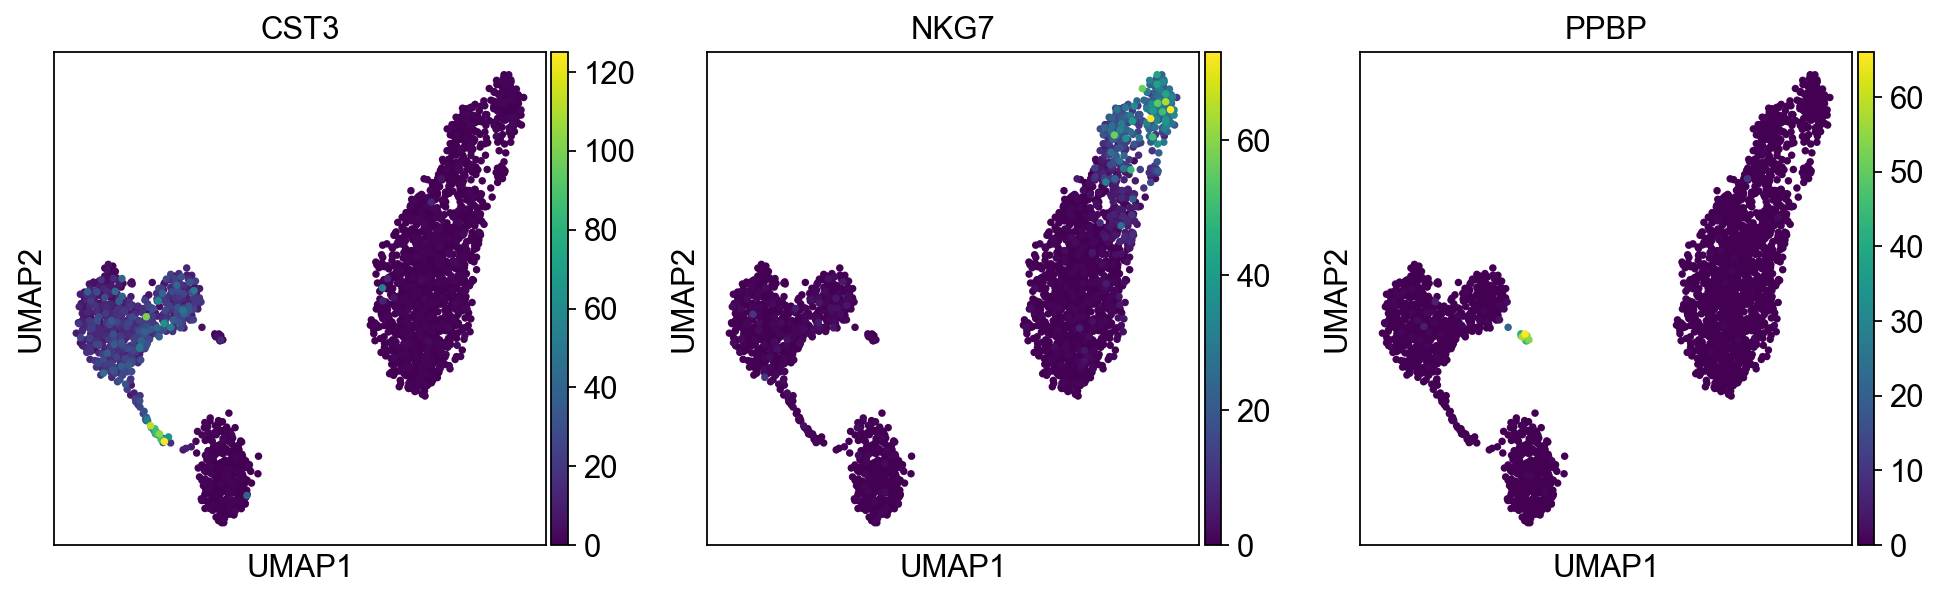

In [23]:
# Using raw gene expression, 
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="counts")

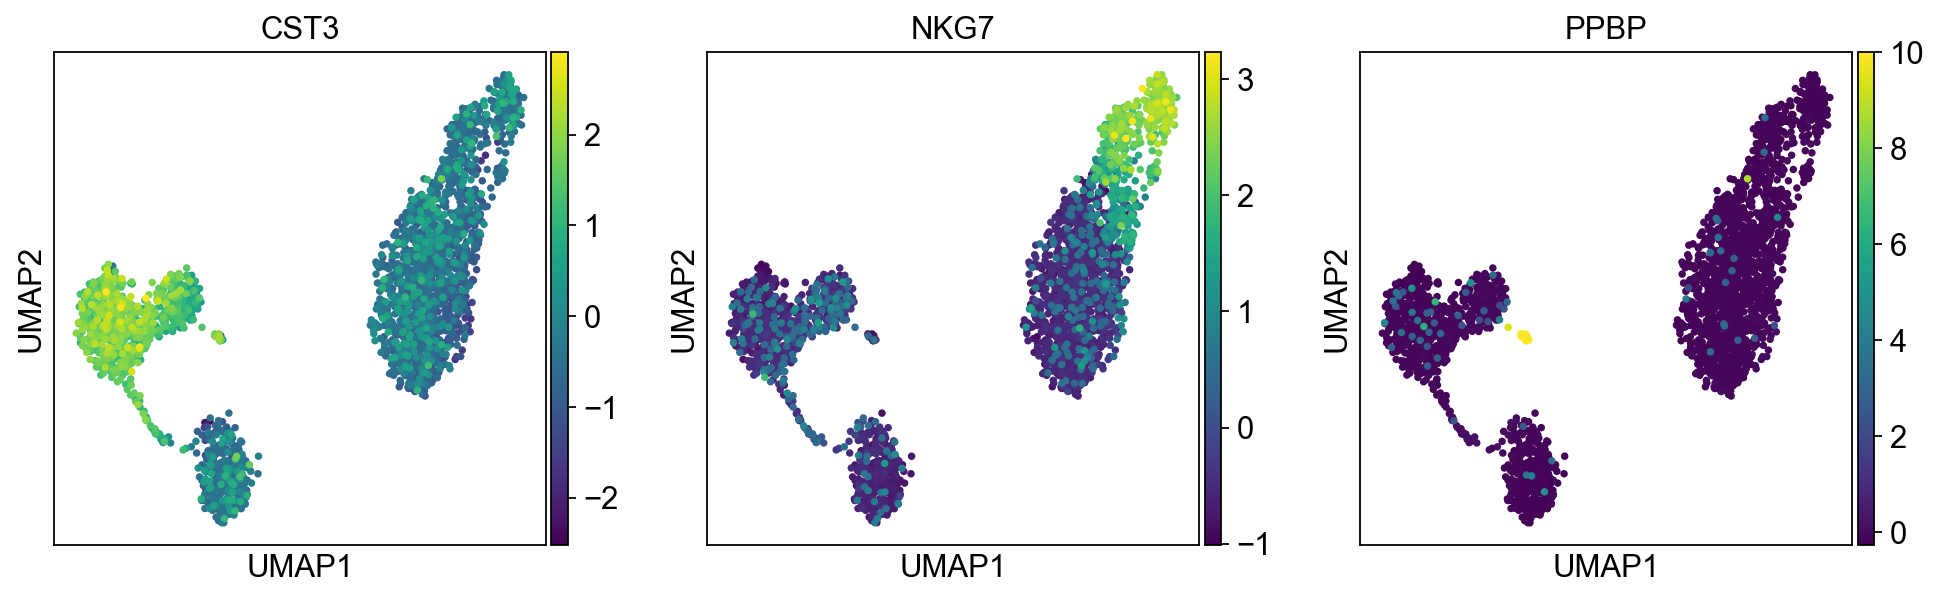

In [24]:
# Using scaled gene expression, 
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="scaled")

## Graph-based Clustering

In [25]:
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
adata.obs["leiden"] = adata.obs["leiden"].copy()
adata.uns["leiden"] = adata.uns["leiden"].copy()
adata.obsm["X_umap"] = adata.obsm["X_umap"].copy()

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


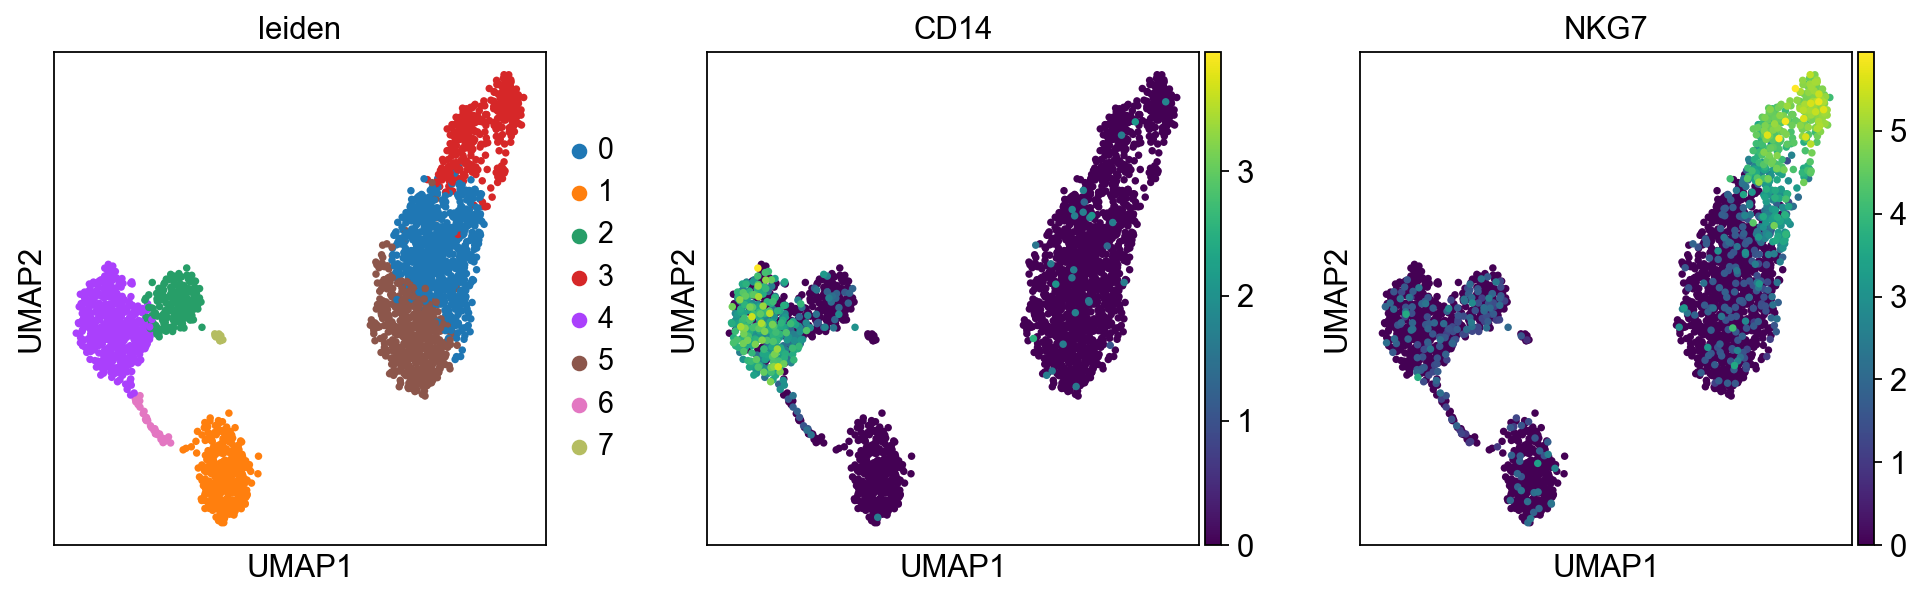

In [26]:
sc.pl.umap(adata, color=["leiden", "CD14", "NKG7"])

## Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


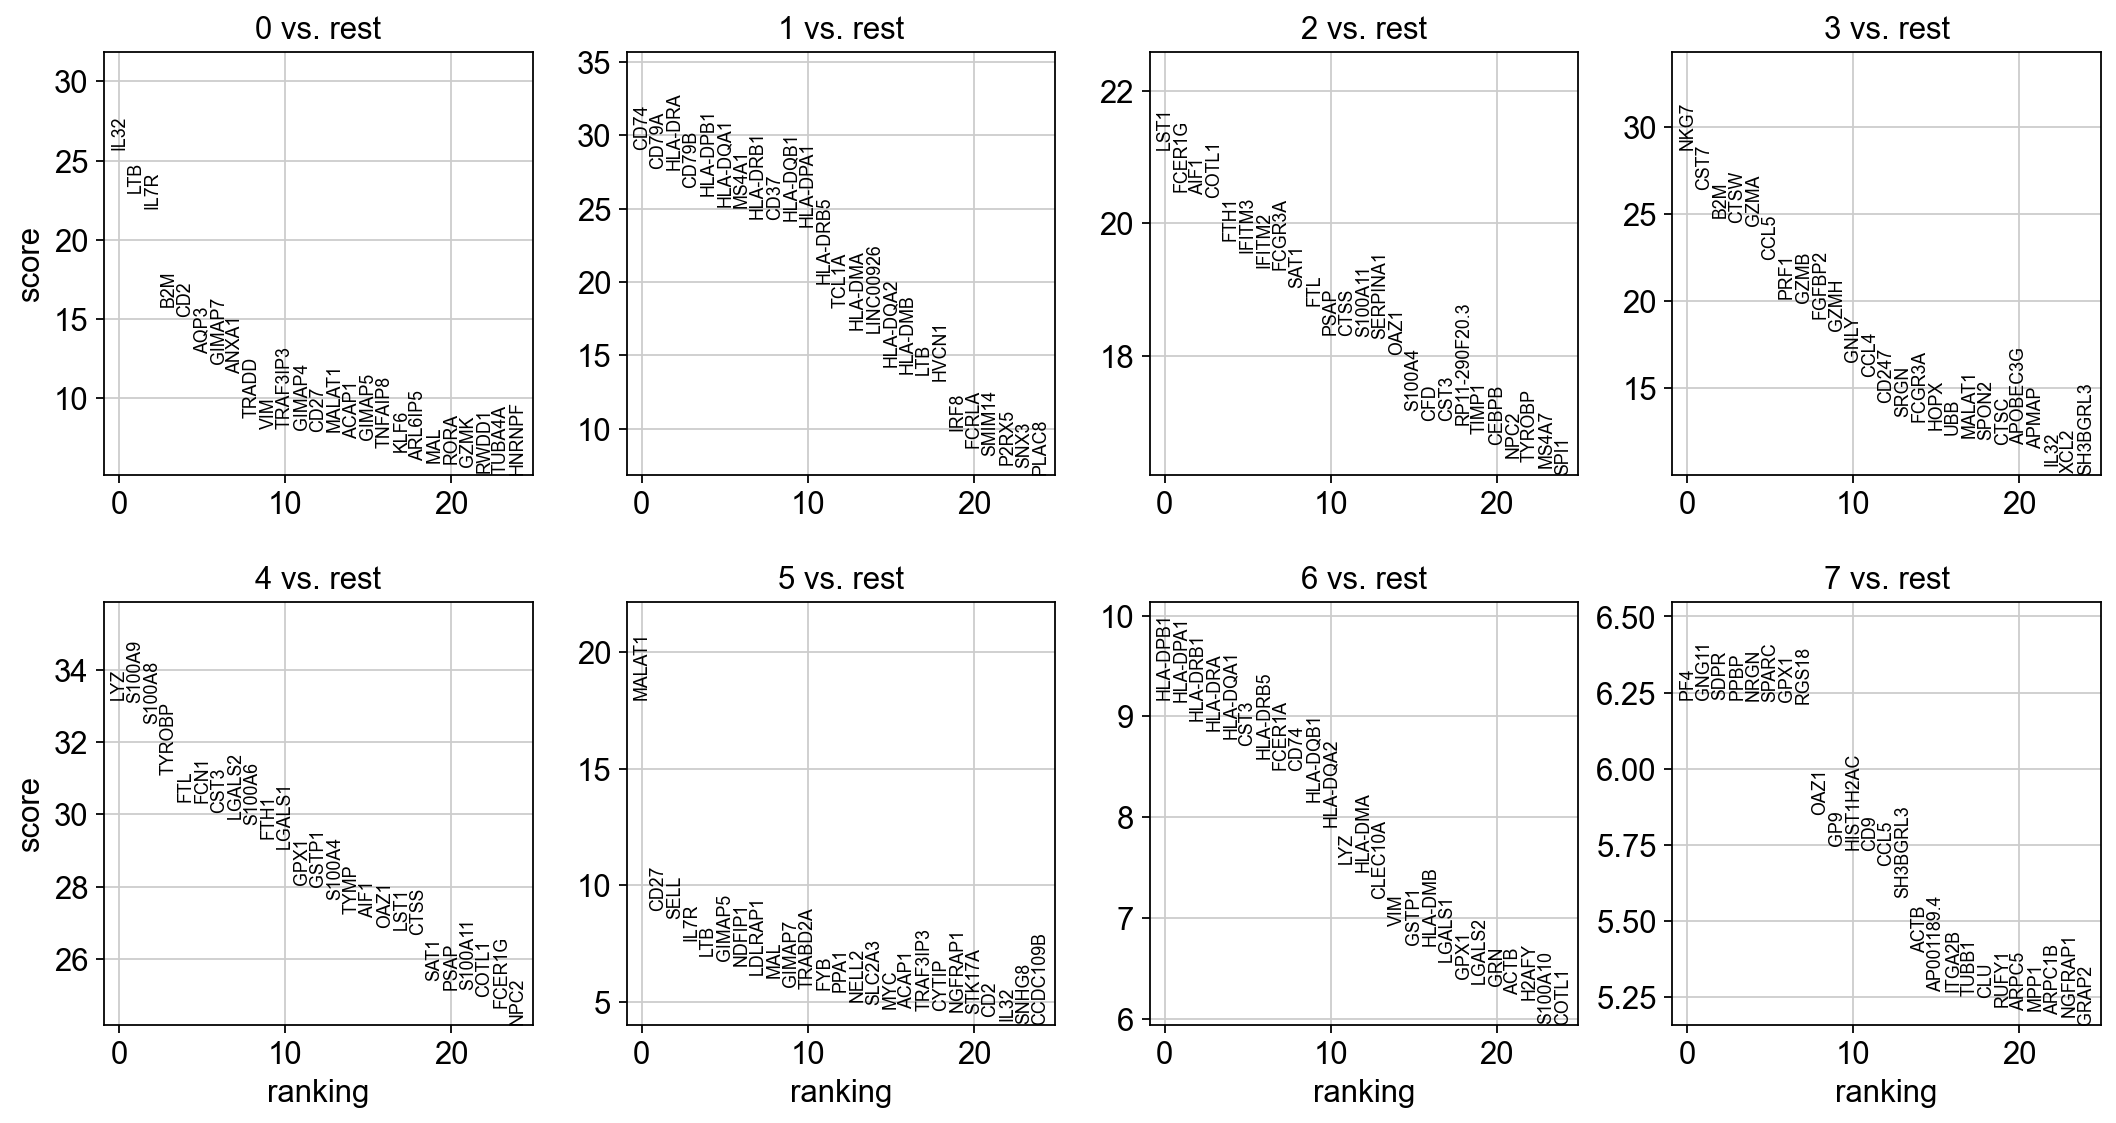

In [27]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [29]:
# Savepoint
adata.write(results_file)

In [30]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [31]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,IL32,CD74,LST1,NKG7,LYZ,MALAT1,HLA-DPB1,PF4
1,LTB,CD79A,FCER1G,CST7,S100A9,CD27,HLA-DPA1,GNG11
2,IL7R,HLA-DRA,AIF1,B2M,S100A8,SELL,HLA-DRB1,SDPR
3,B2M,CD79B,COTL1,CTSW,TYROBP,IL7R,HLA-DRA,PPBP
4,CD2,HLA-DPB1,FTH1,GZMA,FTL,LTB,HLA-DQA1,NRGN


In [32]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame({f"{group}_{key[:1]}": result[key][group] for group in groups for key in ["names", "pvals"]}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,IL32,1.068823e-145,CD74,2.120012e-185,LST1,5.425593e-99,NKG7,4.507025e-181,LYZ,1.686702e-241,MALAT1,2.400260e-72,HLA-DPB1,4.709466e-20,PF4,4.722886e-10
1,LTB,6.153911e-117,CD79A,2.912929e-169,FCER1G,2.873777e-93,CST7,8.801315e-154,S100A9,2.924833e-240,CD27,4.816131e-19,HLA-DPA1,5.936147e-20,GNG11,4.733899e-10
2,IL7R,6.702854e-107,HLA-DRA,3.064120e-168,AIF1,8.440764e-93,B2M,6.667606e-136,S100A8,4.001603e-232,SELL,1.034728e-17,HLA-DRB1,3.166380e-19,SDPR,4.733899e-10
3,B2M,4.886692e-56,CD79B,5.052934e-154,COTL1,2.202854e-92,CTSW,2.311250e-132,TYROBP,1.828610e-212,IL7R,2.147381e-14,HLA-DRA,8.058910e-19,PPBP,4.744938e-10
4,CD2,7.507368e-52,HLA-DPB1,4.254675e-148,FTH1,9.088216e-87,GZMA,6.505851e-131,FTL,2.982456e-202,LTB,2.516114e-12,HLA-DQA1,1.682328e-18,NRGN,4.800511e-10


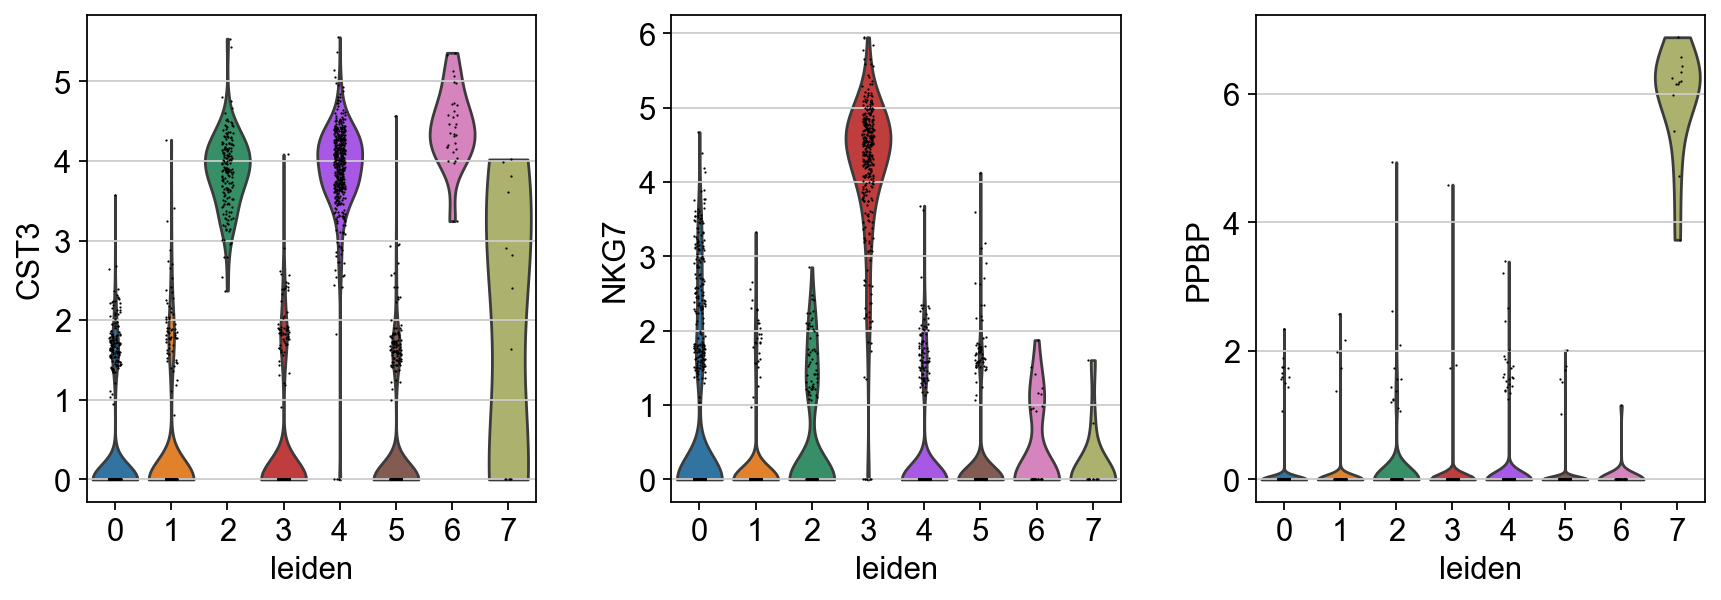

In [33]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

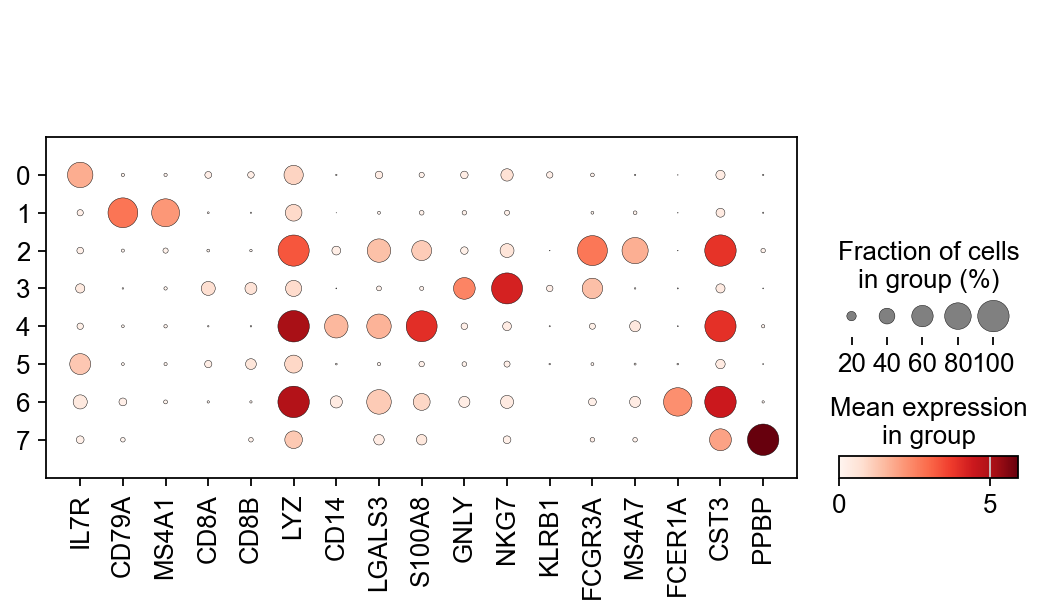

In [34]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

## Cell type annotation

In [37]:
new_cluster_names = {
    '0': 'T',
    '1': 'B', 
    '2': 'CD16+ Mono', 
    '3': 'NK', 
    '4': 'CD14+ Mono', 
    '5': 'T',
    '6': 'DC',
    '7': 'Mega',
}
adata.obs['annotation'] = adata.obs['leiden'].map(new_cluster_names).astype('category')

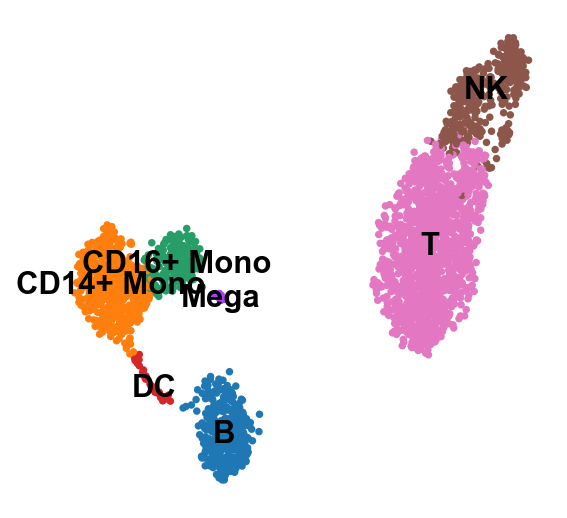

In [38]:
sc.pl.umap(adata, color="annotation", legend_loc="on data", title="", frameon=False, save=".pdf")

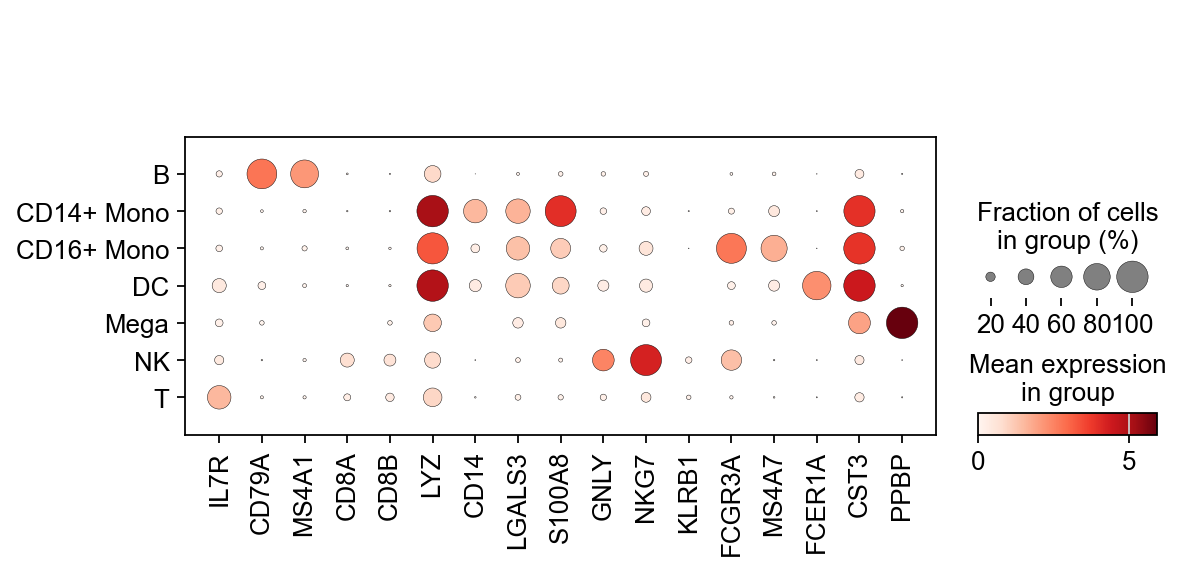

In [39]:
sc.pl.dotplot(adata, marker_genes, groupby="annotation")

In [40]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'annotation'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

## Differentially expressed genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


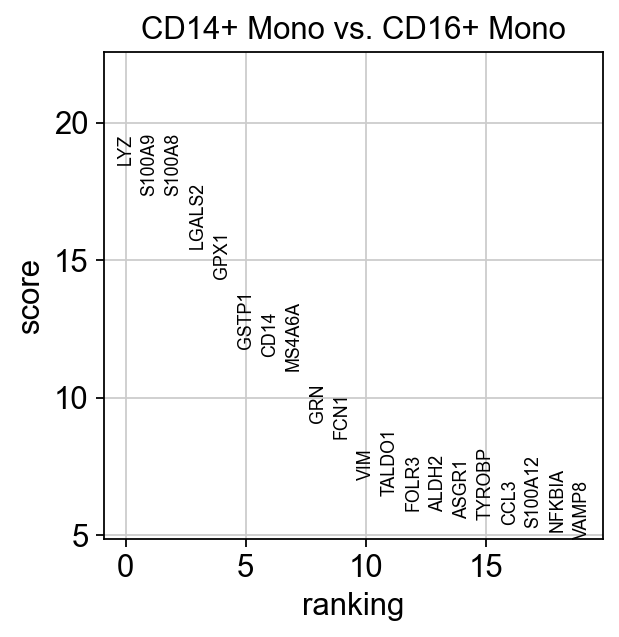

In [41]:
sc.tl.rank_genes_groups(
    adata, 
    "annotation",
    mask_var="highly_variable",
    groups=["CD14+ Mono"],
    reference="CD16+ Mono",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata, groups=["CD14+ Mono"], n_genes=20)

In [42]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame({f"{group}_{key[:1]}": result[key][group] for group in groups for key in ["names", "pvals"]}).head(5)

,CD14+ Mono_n,CD14+ Mono_p
0,LYZ,2.719286e-76
1,S100A9,1.711203e-67
2,S100A8,2.899932e-67
3,LGALS2,1.635436e-53
4,GPX1,1.465536e-46
